# <span style='color:#0D2BA5'>Projet 7 - Implémentez un modèle de scoring</span>

Ce notebook traite de la 'feature sélection' des jeux de données des dataframes **train_set** et **test_set** composés des pré-processing (nettoyage, feature engineering)/aggrégations de tous les fichiers mis à notre disposition:

- **bureau.csv**,
- **bureau_balance.csv**,
- **credit_card_balance.csv**,
- **installments_payments.csv**,
- **POS_CASH_balance.csv**,
- **previous_application.csv**

En particulier :

- **Feature selection** : outre la génération de caractéristiques importantes/utiles, il est également essentiel de supprimer les caractéristiques redondantes et bruyantes. Si nous introduisons des déchets/bruits dans notre modèle d'apprentissage automatique, il retournera des déchets/bruits. Nous devons donc trouver de bonnes techniques de sélection des caractéristiques les plus importantes et discriminantes pour notre problématique.

***
Sources
***
Kernel Kaggle sur Home Credit :
- Feature sélection avec Lightgbm : [Source](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)


## <span style='background:#33B5FF'>Table des Matieres</span> 

In [1]:
#from jyquickhelper import add_notebook_menu
#add_notebook_menu()

## <span style='background:#33B5FF'>1. Introduction</span>

*****
**Mission**
*****
**Développer un modèle de scoring de la probabilité de défaut de paiement du client** pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières...).

*****
**Objectifs**
*****
- analyser le jeu de données,
- Construire **un modèle de scoring** qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique,
- réaliser une API au vue d'un **dashboard interactif** permettant aux chargés de clientèles d'expliquer de manière transparente la décision d'octroi ou non de crédit

*****
**Sources**
*****
- [Jeu de données](https://www.kaggle.com/c/home-credit-default-risk/data)

Le **Kernel Kaggle** utilisé pour l'analyse exploratoire ayant l'EDA le plus de commentaires et effectuant une analyse exploratoire complète sur toutes les fichiers csv mis à notre disposition a été livré par **Rishabh Rao** (Student at -Jaipur, Rajasthan, India).
- [Kernel Kaggle Rishabh Rao](https://www.kaggle.com/rishabhrao/home-credit-default-risk-extensive-eda)

Ce travail est complété par l'auteur par une présentation sur le site medium.com :
[Explications](https://medium.com/thecyphy/home-credit-default-risk-part-1-3bfe3c7ddd7a)

Les fonctions python utilisées pour l'EDA sont extraites du [github](https://github.com/rishabhrao1997/Home-Credit-Default-Risk) et stockées dans la librairie *EDA_KERNEL_FONCTIONS.py*.

In [1]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import warnings
!pip install jyquickhelper --quiet
import jyquickhelper
import numpy as np
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt

# Modelisation
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

!pip install BorutaShap --quiet
# Features selection
from BorutaShap import BorutaShap
from collections import Counter

# Warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
os.chdir(r'/kaggle/working')

/kaggle/input/donnes-feature-s/test_set_preproc.pickle
/kaggle/input/donnes-feature-s/train_set_preproc.pickle
/kaggle/input/tr-dt-proc/eda.py
/kaggle/input/tr-dt-proc/pre_proc_data.py


In [3]:
!pip install boruta --upgrade --quiet

In [4]:
import sys
sys.path.append('/kaggle/input/tr-dt-proc')

In [5]:
import eda
import pre_proc_data

2024-03-01 15:44:21.945303: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 15:44:21.945470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 15:44:22.099629: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
dico_pd_option = {
    'display.max_rows': 400,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 4,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)

## <span style='background:#33B5FF'>2. Chargement des jeux de données</span>

**Chargement des dataframes nettoyés**

In [7]:
fic_sav_train_set = '/kaggle/input/donnes-feature-s/train_set_preproc.pickle'
# Chargement de train_set
with open(fic_sav_train_set, 'rb') as df_appli_train_set:
    train_set = pickle.load(df_appli_train_set)
train_set.shape

(307507, 620)

In [8]:
fic_sav_test_set = \
    '/kaggle/input/donnes-feature-s/test_set_preproc.pickle'
# Chargement de test_set
with open(fic_sav_test_set, 'rb') as df_appli_test_set:
    test_set = pickle.load(df_appli_test_set)
test_set.shape

(48744, 618)

## <span style='background:#33B5FF'>3. Features selection</span> 

### <span >3.1. Features selection : avec LIGHTGBM</span>

- Extrait du Kernel Kaggle : [Source](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
- Le but est de conserver uniquement les variables les plus pertinentes en utilisant les features importance déterminée par un modèle, Lightgbm dans notre cas.

**Préparation des dataframes de travail**

In [9]:
def description_variables(dataframe, type_var='all'):
    """
    Retourne la description des variables qualitatives/quantitatives
    ou toutes les variables du dataframe transmis :
    type, nombre de nan, % de nan et desc
    Parameters
    ----------
    @param IN : dataframe : DataFrame, obligatoire
                type_var = 'all' ==> tous les types de variables (défaut)
                           'cat' ==> variables catégorielles
                           'num' ==> variables quantitative
                           facultatif
    @param OUT : dataframe de description des variables
    """
    df_taille = dataframe.shape[0]

    if type_var == 'num':
        desc_var = dataframe.describe(datetime_is_numeric=True)
    elif type_var == 'cat':
        desc_var = dataframe.describe(
            exclude=[np.number])
    else:
        desc_var = dataframe.describe(include='all')

    desc_type = pd.DataFrame(
        dataframe[desc_var.columns].dtypes, columns=['type']).T
    nb_nan = df_taille - desc_var.loc['count'].T
    pourcentage_nan = nb_nan * 100 / np.product(dataframe.shape)
    desc_nan = pd.DataFrame([nb_nan, pourcentage_nan],
                            index=['nb_nan', '%_nan'])
    desc_var = pd.concat([desc_type, desc_nan, desc_var])

    return desc_var

In [10]:
# Résumé des variables qualitatives
desc_train_set = description_variables(train_set)
desc_train_set

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,INCOME_GOODS_DIFF,INCOME_EXT_RATIO,LAST_PHONE_EMPLOYED_RATIO,CAR_EMPLOYED_RATIO,FLAG_CONTACTS_SUM,CNT_NON_CHILDREN,REGION_RATING_MAX,EXT_SOURCE_SUM,EXT_SOURCE_MAX,EXT_SOURCE_VAR,OBS_DEF_30_MUL,OBS_30_CREDIT_RATIO,FLAGS_DOCUMENTS_SUM,ENQ_CREDIT_RATIO,TARGET_NEIGHBORS_500_MEAN,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_GROUP_OF_PEOPLE,NAME_TYPE_SUITE_OTHER_A,NAME_TYPE_SUITE_OTHER_B,NAME_TYPE_SUITE_SPOUSE_PARTNER,NAME_INCOME_TYPE_BUSINESSMAN,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,NAME_INCOME_TYPE_STATE_SERVANT,NAME_INCOME_TYPE_STUDENT,NAME_INCOME_TYPE_UNEMPLOYED,NAME_INCOME_TYPE_WORKING,...,PREV_APP_DAYS_DECISION_MAX,PREV_APP_SELLERPLACE_AREA_MEAN,PREV_APP_SELLERPLACE_AREA_MIN,PREV_APP_CNT_PAYMENT_MEAN,PREV_APP_NAME_YIELD_GROUP_MEAN,PREV_APP_NAME_YIELD_GROUP_LAST,PREV_APP_DAYS_FIRST_DUE_SUM,PREV_APP_DAYS_LAST_DUE_MAX,PREV_APP_NFLAG_INSURED_ON_APPROVAL_SUM,PREV_APP_AMT_DECLINED_MEAN,PREV_APP_AMT_DECLINED_SUM,PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX,PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN,PREV_APP_AMT_CREDIT_GOODS_DIFF_SUM,PREV_APP_AMT_CREDIT_GOODS_DIFF_MEAN,PREV_APP_AMT_CREDIT_GOODS_DIFF_MAX,PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MEAN,PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MIN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MIN,PREV_APP_AMT_APPLICATION_TO_SELLERPLACE_AREA_MEAN,PREV_APP_ANNUITY_MEAN,PREV_APP_ANNUITY_GOODS_MEAN,PREV_APP_LOAN_RATE_MAX,PREV_APP_LOAN_RATE_MEAN,PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MEAN,PREV_APP_AMT_INTEREST_MEAN,PREV_APP_INTEREST_SHARE_MEAN,PREV_APP_INTEREST_SHARE_MAX,PREV_APP_INTEREST_SHARE_MIN,PREV_APP_INTEREST_RATE_MAX,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MIN_MEAN,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MAX_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MAX_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MEAN_MEAN,PKPRET_BUREAU_BALANCE_STATUS_LAST_MEAN,PKPRET_BUREAU_BALANCE_STATUS_SUM_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN_MEAN,PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST_MEAN,BUREAU_CREDIT_ACTIVE_ACTIVE_SUM,BUREAU_CREDIT_ACTIVE_ACTIVE_COUNT,BUREAU_CREDIT_ACTIVE_ACTIVE_MEAN,BUREAU_CREDIT_ACTIVE_BAD_DEBT_SUM,BUREAU_CREDIT_ACTIVE_SOLD_SUM,BUREAU_CREDIT_ACTIVE_SOLD_MEAN,BUREAU_CREDIT_CURRENCY_CURRENCY_1_MEAN,BUREAU_CREDIT_CURRENCY_CURRENCY_2_SUM,BUREAU_CREDIT_CURRENCY_CURRENCY_3_SUM,BUREAU_CREDIT_CURRENCY_CURRENCY_3_MEAN,BUREAU_CREDIT_CURRENCY_CURRENCY_4_SUM,BUREAU_CREDIT_TYPE_ANOTHER_TYPE_OF_LOAN_SUM,BUREAU_CREDIT_TYPE_ANOTHER_TYPE_OF_LOAN_MEAN,BUREAU_CREDIT_TYPE_CAR_LOAN_SUM,BUREAU_CREDIT_TYPE_CAR_LOAN_MEAN,BUREAU_CREDIT_TYPE_CASH_LOAN_NON_EARMARKED__SUM,BUREAU_CREDIT_TYPE_CONSUMER_CREDIT_MEAN,BUREAU_CREDIT_TYPE_CREDIT_CARD_SUM,BUREAU_CREDIT_TYPE_INTERBANK_CREDIT_SUM,B

In [11]:
# Dataframes de travail
train_fs_lgbm = train_set.copy()
print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
test_fs_lgbm = test_set.copy()
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 620)
test_fs_lgbm : (48744, 618)


In [12]:
# Sauvegarde des étiquettes car l'alignement supprimera
# cette variable.
train_fs_lgbm_labels = train_fs_lgbm['TARGET']
# Sauvegarde des identifiants
train_fs_lgbm_ids = train_fs_lgbm['SK_ID_CURR']
test_fs_lgbm_ids = test_fs_lgbm['SK_ID_CURR']
# Alignement des dataframes (suppression variable TARGET)
train_fs_lgbm, test_fs_lgbm = train_fs_lgbm.align(test_fs_lgbm,
                                                  join='inner', axis=1)
# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_fs_lgbm = train_fs_lgbm.drop(columns=['SK_ID_CURR'])
test_fs_lgbm = test_fs_lgbm.drop(columns=['SK_ID_CURR'])
print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 563)
test_fs_lgbm : (48744, 563)


**Modélisation**

***Premier passage***

In [13]:
# Initialiser un tableau vide pour contenir les features importance
feature_importances = np.zeros(train_fs_lgbm.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='goss',
                           n_estimators=100,
                           class_weight='balanced',
                           verbose=200)

In [14]:
# Entraînement du modèle deux fois pour éviter l'overfitting
for i in range(2):

    # Split en jeux d'entraînement et de validation
    train_features, valid_features, train_y, valid_y = \
        train_test_split(train_fs_lgbm, train_fs_lgbm_labels,
                         test_size=0.25, random_state=i)

    # Entraînement en utilisant early stopping
    model.fit(train_features, train_y,
              eval_set=[(valid_features, valid_y)],
              eval_metric='auc')

    # Sauvegarde des features importances
    feature_importances += model.feature_importances_

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 18668, number of negative: 211962
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.925631
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.706287
[LightGBM] [Debug] init for col-wise cost 0.486942 seconds, init for row-wise cost 0.841928 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.669699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] 

In [15]:
# Assurez-vous de faire la moyenne des features importance !
# puisque le modèle a été entraîné 2 fois
feature_importances = feature_importances / 2
df_fs_lightgbm = \
    pd.DataFrame({'feature': list(train_fs_lgbm.columns),
                  'importance': feature_importances}) \
    .sort_values('importance', ascending=False)
df_fs_lightgbm.head()

,feature,importance
84,TARGET_NEIGHBORS_500_MEAN,146.0
227,INST_PAY_DAYS_PAYMENT_RATIO_MAX,82.0
9,DAYS_BIRTH,63.5
10,DAYS_EMPLOYED,61.0
77,EXT_SOURCE_SUM,59.5


In [16]:
# Exploration des variables avec zéro importance
# Find the features with zero importance
zero_features = \
    list(df_fs_lightgbm[df_fs_lightgbm['importance'] == 0.0]['feature'])
print(f'{len(zero_features)} variables avec 0.0 importance :\n')
zero_features

235 variables avec 0.0 importance :



['POS_CASH_NAME_CONTRACT_STATUS_DEMAND_SUM',
 'NAME_INCOME_TYPE_BUSINESSMAN',
 'POS_CASH_NAME_CONTRACT_STATUS_CANCELED_SUM',
 'NAME_INCOME_TYPE_UNEMPLOYED',
 'POS_CASH_NAME_CONTRACT_STATUS_APPROVED_SUM',
 'NAME_INCOME_TYPE_STUDENT',
 'POS_CASH_NAME_CONTRACT_STATUS_AMORTIZED_DEBT_SUM',
 'NAME_TYPE_SUITE_GROUP_OF_PEOPLE',
 'ORGANIZATION_TYPE_AGRICULTURE',
 'NAME_TYPE_SUITE_OTHER_B',
 'NAME_TYPE_SUITE_OTHER_A',
 'ORGANIZATION_TYPE_ADVERTISING',
 'NAME_TYPE_SUITE_CHILDREN',
 'ORGANIZATION_TYPE_RESTAURANT',
 'FLAG_CONTACTS_SUM',
 'ORGANIZATION_TYPE_RELIGION',
 'CCB_NAME_CONTRACT_STATUS_SIGNED_SUM',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'ORGANIZATION_TYPE_CLEANING',
 'FLAG_DOCUMENT_21',
 'ORGANIZATION_TYPE_SECURITY',
 'PREV_APP_NFLAG_LAST_APPL_IN_DAY_MEAN',
 'POS_CASH_NAME_CONTRACT_STATUS_XNA_SUM',
 'NAME_FAMILY_STATUS_WIDOW',
 'REGION_RATING_MEAN_2_5',
 'PREV_APP_PRODUCT_COMBINATION_CASH_X_SELL_LOW_SUM',
 'OCCUPATION_TYPE_IT_STAFF',
 'REGION_RATING_MUL_3',
 'ORGANIZATION_TYPE_SERVICES',
 'ORGANIZA

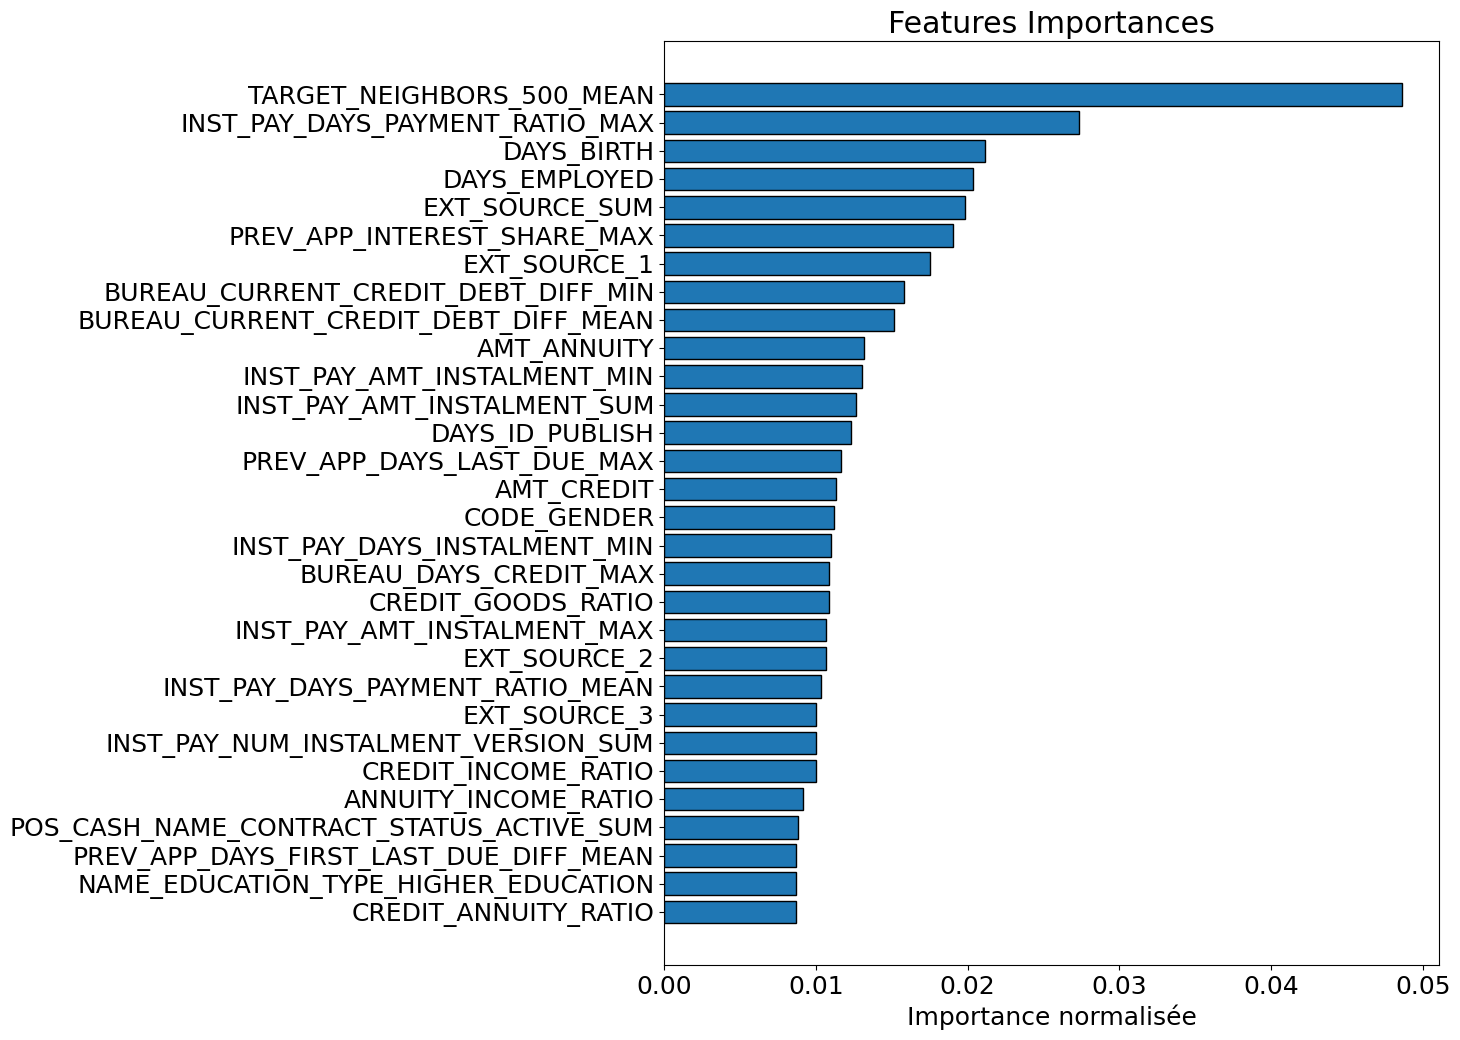

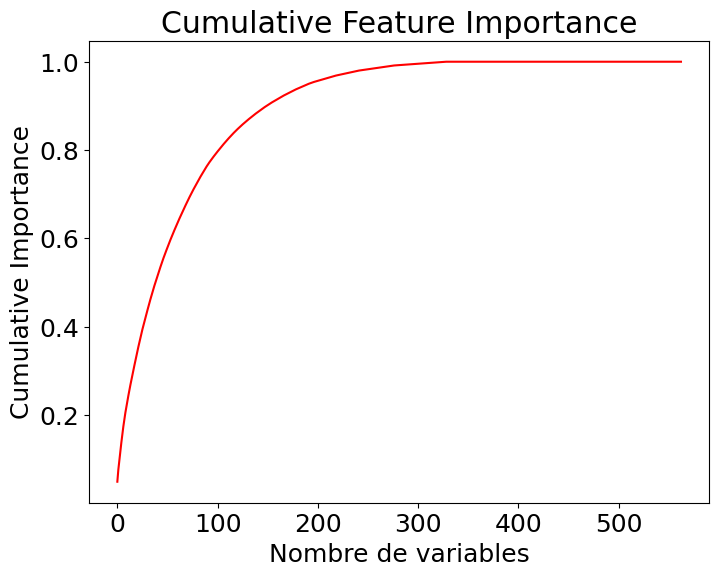

150 variables nécessaires pour 0.90 de cumulative importance


In [17]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm = eda.plot_feature_importances(df_fs_lightgbm)

In [18]:
# Suppression des variables avec zéro importance
train_fs_lgbm = train_fs_lgbm.drop(columns=zero_features)
test_fs_lgbm = test_fs_lgbm.drop(columns=zero_features)

print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 328)
test_fs_lgbm : (48744, 328)


***Second passage***

In [ ]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_2, df_fs_lightgbm_2 = eda.identify_zero_importance_features(train_fs_lgbm,
                                       train_fs_lgbm_labels)

In [ ]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm_2 = eda.plot_feature_importances(df_fs_lightgbm_2)

In [ ]:
# Suppression des variables avec zéro importance
train_fs_lgbm = train_fs_lgbm.drop(columns=zero_features_2)
test_fs_lgbm = test_fs_lgbm.drop(columns=zero_features_2)

print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

***Troisième passage***

In [ ]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_3, df_fs_lightgbm_3 = eda.identify_zero_importance_features(train_fs_lgbm,
                                       train_fs_lgbm_labels)

In [ ]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm_3 = eda.plot_feature_importances(df_fs_lightgbm_3)

In [ ]:
# Suppression des variables avec zéro importance
train_fs_lgbm = train_fs_lgbm.drop(columns=zero_features_3)
test_fs_lgbm = test_fs_lgbm.drop(columns=zero_features_3)

print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

***Quatrième passage***

In [ ]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_4, df_fs_lightgbm_4 = eda.identify_zero_importance_features(train_fs_lgbm,
                                       train_fs_lgbm_labels)

In [ ]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm_4 = eda.plot_feature_importances(df_fs_lightgbm_4)

**Reconstitution des dataframes**

In [ ]:
train_fs_lgbm['TARGET'] = train_fs_lgbm_labels
train_fs_lgbm['SK_ID_CURR'] = train_fs_lgbm_ids
print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
test_fs_lgbm['SK_ID_CURR'] = test_fs_lgbm_ids
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

**Sauvegarde**

In [ ]:
# Sauvegarde des features importances avec lightgbm
fic_sav_fs_lightgbm = '/kaggle/working/fs_lightgbm.pickle'
with open(fic_sav_fs_lightgbm, 'wb') as f:
    pickle.dump(df_fs_lightgbm_4, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Sauvegarde .CSV 
df_fs_lightgbm_4.to_csv('norma_lightgbm.csv')

**Chargement du dataframe sauvegardé**

In [ ]:
# Chargement des features importance de ligthgbm
fic_sav_fs_train_set = '/kaggle/working/fs_lightgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_train_set, 'rb') as df_fs_train_set:
    df_fs_lightgbm = pickle.load(df_fs_train_set)
df_fs_lightgbm.shape

In [ ]:
# Sauvegarde du nombre de features importance
df_fs_train_set = pd.DataFrame({})
df_fs_train_set = pre_proc_data.tracer_features_importance(df_fs_lightgbm,
                                                    df_fs_train_set,
                                                    'train_set',
                                                    'lightgbm')

### <span style='background:PowderBlue'>3.4. Features selection : avec permutation importance</span>

**Préparation du dataframe de travail**

In [ ]:
# Dataframes de travail
train_fs_perm = train_set.copy()
print(f'train_fs_perm : {train_fs_perm.shape}')

In [ ]:
# Sauvegarde des étiquettes
train_fs_perm_labels = train_fs_perm['TARGET']

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_fs_perm = train_fs_perm.drop(columns=['SK_ID_CURR'])
train_fs_perm = train_fs_perm.drop(columns=['TARGET'])

print(f'train_fs_perm : {train_fs_perm.shape}')

In [ ]:
# Initialisation des variables
X = train_fs_perm
y = train_fs_perm_labels

In [ ]:
# Create the model with several hyperparameters
lgbm = lgb.LGBMClassifier(objective='binary',
                          data_sample_strategy = 'goss',
                          n_estimators=1000,
                          class_weight='balanced',
                          verbose=200
                         )

In [ ]:
# Split en jeux d'entraînement et de validation
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.25, random_state=21)

# Entraînement en utilisant early stopping
lgbm.fit(X_train, y_train,
         eval_set=[(X_test, y_test)],
         eval_metric='auc')

<span style='background:Plum'>**Permutation-based Importance avec sklearn**</span>

In [ ]:
# Feature importance par permutation importance avec sklearn
perm_imp_sklearn = pre_proc_data.plot_permutation_importance(lgbm, X_test, y_test, figsize=(6, 100))fever

In [ ]:
# Constitution du dataframe de travail
df_fs_perm_imp_sklearn = pd.DataFrame({'Variables': X_test.columns,
                  'Importance': perm_imp_sklearn.importances_mean,
                  'Importance_abs': np.abs(perm_imp_sklearn.importances_mean)})

In [ ]:
# Variables sans zéros importances
fs_perm_imp_sklearn = df_fs_perm_imp_sklearn[df_fs_perm_imp_sklearn['Importance_abs'] != 0.000]
print(f'{fs_perm_imp_sklearn.shape[0]} variables sans zéro importance')
#B

In [ ]:
# Affichage des 100 variables les plus importantes
df_fs_perm_imp_sklearn_plot = \
    df_fs_perm_imp_sklearn.sort_values(by='Importance_abs',
                                       ascending=False)

plt.figure(figsize=(6, 20))
plt.barh(df_fs_perm_imp_sklearn_plot['Variables'].head(100),
         df_fs_perm_imp_sklearn_plot['Importance_abs'].head(100))
plt.xlabel("Permutation Importance (%)")
plt.show()

In [ ]:
df_fs_perm_imp_sklearn = pd.DataFrame(fs_perm_imp_sklearn['Variables'])
df_fs_perm_imp_sklearn.shape[0]

**Sauvegarde**

In [ ]:
# Sauvegarde des features importances avec permutation importance sklearn
fic_sav_perm_imp_sklearn_lgbm = \
    '/kaggle/working/perm_imp_sklearn.pickle'
with open(fic_sav_perm_imp_sklearn_lgbm, 'wb') as f:
    pickle.dump(perm_imp_sklearn, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Sauvegarde des features importances avec permutation importance sklearn
fic_sav_fs_perm_imp_sklearn_lgbm = \
    '/kaggle/working/fs_perm_imp_sklearn.pickle'
with open(fic_sav_fs_perm_imp_sklearn_lgbm, 'wb') as f:
    pickle.dump(df_fs_perm_imp_sklearn, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [ ]:
# Chargement des features importance de sklearn perm imp
fic_sav_fs_perm_imp_sklearn = \
    '/kaggle/input/enregis/fs_perm_imp_sklearn.pickle'
# Chargement des features importance
with open(fic_sav_fs_perm_imp_sklearn, 'rb') as df_fs_perm_imp_sklearn:
    df_fs_perm_imp_sklearn = pickle.load(df_fs_perm_imp_sklearn)
df_fs_perm_imp_sklearn.shape

In [ ]:
# Chargement des features importance de sklearn perm imp
fic_sav_perm_imp_sklearn = \
    '/kaggle/input/enregis/perm_imp_sklearn.pickle'
# Chargement des features importance
with open(fic_sav_perm_imp_sklearn, 'rb') as perm_imp_sklearn:
    perm_imp_sklearn = pickle.load(perm_imp_sklearn)
perm_imp_sklearn

In [ ]:
# Sauvegarde du nombre de features importance
df_fs_train_set = pre_proc_data \
    .tracer_features_importance(df_fs_perm_imp_sklearn,
                                df_fs_train_set,
                                'train_set',
                                'permutation-importance-LightGbm')

### <span style='background:PowderBlue'>3.6. Bilan - Jeux de données finaux</span>

<span style='background:Moccasin'>**Train_set/test_set**</span>

Les différents dataframes des variables avec hautes importances avec les features importance d'un modèle Lightgbm ou RandomForest, les librairies les permutations importances avec les librairies scikit-learn pour le jeu de données train set sont :
- [x] df_fs_lightgbm,
- [x] df_fs_perm_imp_sklearn,

**Répétitions des variables conservées**

In [ ]:
# Récupération des variables conservées pour chaque feature selection
liste_var = df_fs_lightgbm['feature'].to_list()
print(len(liste_var))
liste_var.extend(df_fs_perm_imp_sklearn['Variables'].to_list())
print(len(liste_var))

In [ ]:
# Nomre de répétitions de chacune des variables
dico_nbre_repet_var = Counter(liste_var)
len(dico_nbre_repet_var)

In [ ]:
df_nbr_repet_var = pd.DataFrame.from_dict(dico_nbre_repet_var,
                                          orient='index',
                                          columns=['Nbr_repetition'])\
    .reset_index().rename(columns={'index':'Variables'}) \
    .sort_values(by='Nbr_repetition', ascending=False)
df_nbr_repet_var.style.hide()

In [ ]:
def distribution_variables_plages(
        dataframe, variable, liste_bins):
    """
    Retourne les plages des pourcentages des valeurs pour le découpage transmis
    Parameters
    ----------
    @param IN : dataframe : DataFrame, obligatoire
                variable : variable à découper obligatoire
                liste_bins: liste des découpages facultatif int ou pintervallindex
    @param OUT : dataframe des plages de nan
    """
    nb_lignes = len(dataframe[variable])
    s_gpe_cut = pd.cut(
        dataframe[variable],
        bins=liste_bins).value_counts().sort_index()
    df_cut = pd.DataFrame({'Plage': s_gpe_cut.index,
                           'nb_données': s_gpe_cut.values})
    df_cut['%_données'] = [
        (row * 100) / nb_lignes for row in df_cut['nb_données']]

    return df_cut.style.hide()

In [ ]:
# Plage de nombre de répétitions
liste_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
distribution_variables_plages(df_nbr_repet_var,
                                          'Nbr_repetition',
                                          liste_bins)

In [ ]:
# Les variables présentes plus de 2 fois pour les 2 méthodes de feature
#  sélection seront conservées
var_cons_train_set = \
    df_nbr_repet_var[df_nbr_repet_var['Nbr_repetition'] >= 2][
        'Variables'].to_list()
print(f'{len(var_cons_train_set)} variables conservées pour le train_set')
var_cons_train_set

In [ ]:
# Sauvegarde des variables conservées pour le train_set
fic_sav_var_cons_train_set = \
    '/kaggle/working/var_cons_train_set.pickle'
with open(fic_sav_var_cons_train_set, 'wb') as f:
    pickle.dump(var_cons_train_set, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Chargement des variables conservées pour le train_set
fic_sav_var_cons_train_set = \
    '/kaggle/working/var_cons_train_set.pickle'
with open(fic_sav_var_cons_train_set, 'rb') as df_var_cons_train_set:
    var_cons_train_set = pickle.load(df_var_cons_train_set)
len(var_cons_train_set)

**Test en ne conservant que les variables les plus sélectionnées par feature selection**

In [ ]:
# Les variables présentes plus de 6 fois pour les 8 méthodes de feature
#  sélection seront conservées
var_cons_train_set_small = \
    df_nbr_repet_var[df_nbr_repet_var['Nbr_repetition'] >= 2][
        'Variables'].to_list()
print(f'{len(var_cons_train_set_small)} variables conservées pour le train_set')
var_cons_train_set_small

In [ ]:
# Sauvegarde des variables conservées pour le train_set réduit
fic_sav_var_cons_train_set_small = \
    '/kaggle/working/var_cons_train_set_small.pickle'
with open(fic_sav_var_cons_train_set_small, 'wb') as f:
    pickle.dump(var_cons_train_set_small, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Chargement des variables conservées pour le train_set réduit
fic_sav_var_cons_train_set_small = \
    '/kaggle/working/var_cons_train_set_small.pickle'
with open(fic_sav_var_cons_train_set_small, 'rb') as df_var_cons_train_set_small:
    var_cons_train_set_small = pickle.load(df_var_cons_train_set_small)
len(var_cons_train_set_small)

**Constitution des dataframes train_set et test_set finaux**

In [ ]:
# Constitution du train_set
print(f'{train_set.shape}')
# Ajout de l'identifiant du client et de la variable cible
var_cons_train_set_avec_target_id = ['SK_ID_CURR', 'TARGET']
var_cons_train_set_avec_target_id.extend(var_cons_train_set)
train_set = train_set[var_cons_train_set_avec_target_id]
print(f'{train_set.shape}')

In [ ]:
# Constitution du test_set
print(f'{test_set.shape}')
# Ajout de l'identifiant du client
var_cons_train_set_avec_id = ['SK_ID_CURR']
var_cons_train_set_avec_id.extend(var_cons_train_set)
test_set = test_set[var_cons_train_set_avec_id]
print(f'{test_set.shape}')

In [ ]:
# Constitution du train_set réduit
train_set_small = train_set.copy()
print(f'{train_set_small.shape}')
# Ajout de l'identifiant du client et de la variable cible
var_cons_train_set_small_avec_target_id = ['SK_ID_CURR', 'TARGET']
var_cons_train_set_small_avec_target_id.extend(var_cons_train_set_small)
train_set_small = train_set_small[var_cons_train_set_small_avec_target_id]
print(f'{train_set_small.shape}')

In [ ]:
# Constitution du test_set réduit
test_set_small = test_set.copy()
print(f'{test_set_small.shape}')
# Ajout de l'identifiant du client
var_cons_train_set_small_avec_id = ['SK_ID_CURR']
var_cons_train_set_small_avec_id.extend(var_cons_train_set_small)
test_set_small = test_set_small[var_cons_train_set_small_avec_id]
print(f'{test_set_small.shape}')

**Sauvegarde**

In [ ]:
# Sauvegarde du train_set après nettoyage, feature engineering et
# feature selection
fic_sav_train_set = \
    '/kaggle/working/train_set.pickle'
with open(fic_sav_train_set, 'wb') as f:
    pickle.dump(train_set, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
train_set.to_csv('train_set.csv', index=False)

In [ ]:
# Sauvegarde du test_set après nettoyage, feature engineering et
# feature selection
fic_sav_test_set = \
    '/kaggle/working/test_set.pickle'
with open(fic_sav_test_set, 'wb') as f:
    pickle.dump(test_set, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
test_set.to_csv('test_set.csv', index=False)

In [ ]:
# Sauvegarde du train_set réduit après nettoyage, feature engineering et
# feature selection
fic_sav_train_set_small = \
    '/kaggle/working/train_set_small.pickle'
with open(fic_sav_train_set_small, 'wb') as f:
    pickle.dump(train_set_small, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
train_set_small.to_csv('train_set_small.csv', index=False)

In [ ]:
# Sauvegarde du test_set réduit après nettoyage, feature engineering et
# feature selection
fic_sav_test_set_small = \
    '/kaggle/working/test_set_small.pickle'
with open(fic_sav_test_set_small, 'wb') as f:
    pickle.dump(test_set_small, f, pickle.HIGHEST_PROTOCOL)
    
    
    

In [ ]:
# Export en fichier .csv
test_set_small.to_csv('test_set_small.csv', index=False)

**Chargement**

In [ ]:
# Chargement du train_set
fic_sav_train_set_small = \
    '/kaggle/working/train_set_small.pickle'
with open(fic_sav_train_set_small, 'rb') as df_train_set_small:
    train_set_small = pickle.load(df_train_set_small)
train_set_small.shape

In [ ]:
# Chargement du test_set
fic_sav_test_set_small = \
    '/kaggle/working/test_set_small.pickle'
with open(fic_sav_test_set_small, 'rb') as df_test_set_small:
    test_set_small = pickle.load(df_test_set_small)
test_set_small.shape


***
Les jeux de données sont nettoyés, encodés, features engineering et features sélection effectués. Les données sont prêtes pour la partie Machine Learning traitée dans le notebook Notebook_Modelisation.ipynb.
***